In [141]:
import sys
sys.path.append("../../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

DATE_CONFIG = {
    'TRAIN_START': pd.Timestamp('2021-02-02'),
    'TRAIN_END': pd.Timestamp('2024-01-01'),
    'TEST_END': pd.Timestamp('2025-01-01'),
    'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [142]:
def load_and_prepare_data(file_path, train_start, train_end):  # Funktion angepasst
    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])

    mask = (df['date'] >= train_start) & \
           (df['date'] <= train_end)
    df = df[mask]

    price_matrix = df.pivot(index='date', columns='symbol', values='close')

    symbols = price_matrix.columns.tolist()

    print(f"Loaded data from {train_start} to {train_end}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")

    return df, price_matrix, symbols

In [143]:
import toml

with open("../config.toml", "r") as f:
    config = toml.load(f)
    

df, price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'], DATE_CONFIG['TRAIN_START'],
                                                      DATE_CONFIG['TRAIN_END'])

Loaded data from 2021-02-02 00:00:00 to 2024-01-01 00:00:00
Total symbols: 94
Total trading days: 733


In [144]:
returns_matrix = price_matrix.pct_change()
returns_matrix = returns_matrix.dropna() 

In [145]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_returns = pd.DataFrame(
    scaler.fit_transform(returns_matrix),
    index=returns_matrix.index,
    columns=returns_matrix.columns
)

In [146]:
def calculate_rolling_correlation(returns_df, window=250):
    pairs_corr = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            rolling_corr = returns_df[[sym1, sym2]].rolling(window=window)\
                          .corr()\
                          .unstack()[sym2][sym1]
                          
            pairs_corr[pair_key] = rolling_corr
            
    return pd.DataFrame(pairs_corr)

rolling_correlations = calculate_rolling_correlation(standardized_returns)
rolling_correlations = rolling_correlations.dropna()

In [147]:
def calculate_rolling_betas(returns_df, window=250):
    pairs_beta = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            x = returns_df[sym2]
            y = returns_df[sym1]
            
            rolling_cov = y.rolling(window=window).cov(x)
            rolling_var = x.rolling(window=window).var()
            rolling_beta = rolling_cov / rolling_var
            
            pairs_beta[pair_key] = rolling_beta
            
    return pd.DataFrame(pairs_beta)

rolling_betas = calculate_rolling_betas(standardized_returns)
rolling_betas = rolling_betas.dropna()

In [148]:
def calculate_residuals_std(returns_df, window=250):
    pairs_residuals = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            x = returns_df[sym2].values
            y = returns_df[sym1].values
            
            residuals = [np.nan] * len(returns_df)
            for k in range(window, len(returns_df) + 1):
                window_x = x[k-window:k]
                window_y = y[k-window:k]
                coeffs = np.polyfit(window_x, window_y, 1)
                pred = np.polyval(coeffs, window_x)
                window_residuals = window_y - pred
                residuals[k-1] = np.std(window_residuals)
                
            pairs_residuals[pair_key] = residuals
            
    return pd.DataFrame(pairs_residuals, index=returns_df.index)

rolling_residuals_std = calculate_residuals_std(standardized_returns)
rolling_residuals_std = rolling_residuals_std.dropna()

In [149]:
def calculate_spread_deviation(returns_df, window=250, holding_period=5, zscore_threshold=2):
    pairs_spread_dev = {}
    symbols = returns_df.columns
    
    for i in range(len(symbols)):
        for j in range(i+1, len(symbols)):
            sym1, sym2 = symbols[i], symbols[j]
            pair_key = f"{sym1}_{sym2}"
            
            spread = returns_df[sym1] - returns_df[sym2]
            rolling_mean = spread.rolling(window=window).mean()
            rolling_std = spread.rolling(window=window).std()
            zscore = (spread - rolling_mean) / rolling_std
            
            entry_signals = abs(zscore) > zscore_threshold
            spread_changes = []
            
            for k in range(window, len(returns_df) - holding_period):
                if entry_signals.iloc[k]:
                    spread_t0 = spread.iloc[k]
                    spread_t1 = spread.iloc[k + holding_period]
                    spread_change = abs(spread_t1 - spread_t0)
                    spread_changes.append(spread_change)
            
            if spread_changes:
                pairs_spread_dev[pair_key] = np.mean(spread_changes)
            else:
                pairs_spread_dev[pair_key] = np.nan
                
    return pd.Series(pairs_spread_dev)

average_spread_deviation = calculate_spread_deviation(standardized_returns)
average_spread_deviation = average_spread_deviation.dropna()

print(f"Anzahl der berechneten Paare: {len(average_spread_deviation)}")
print("\nTop 5 Paare mit niedrigster Spread-Abweichung:")
print(average_spread_deviation.nsmallest(5))

Anzahl der berechneten Paare: 4371

Top 5 Paare mit niedrigster Spread-Abweichung:
GOOG_GOOGL    0.206049
AMAT_LRCX     0.954980
CDNS_SNPS     1.157174
AMAT_KLAC     1.217065
ASML_LRCX     1.238483
dtype: float64


In [150]:
feature_df = pd.DataFrame({
   'correlation': rolling_correlations.iloc[-1],
   'beta': rolling_betas.iloc[-1],
   'residuals_std': rolling_residuals_std.iloc[-1]
})

feature_df['target'] = average_spread_deviation
feature_df = feature_df.dropna()

volume_matrix = df.pivot(index='date', columns='symbol', values='volume')

In [151]:
def calculate_volume_features(volume_df, pairs, windows=[50, 100]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for window in windows:
            vol1 = volume_df[sym1].rolling(window=window)
            vol2 = volume_df[sym2].rolling(window=window)
            
            pair_features[f'vol_avg_{window}'] = ((vol1.mean() + vol2.mean()) / 2).iloc[-1]
            pair_features[f'vol_std_{window}'] = ((vol1.std() + vol2.std()) / 2).iloc[-1]
            pair_features[f'vol_change_{window}'] = ((volume_df[sym1].pct_change() + volume_df[sym2].pct_change()) / 2).rolling(window=window).mean().iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [152]:
volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df[['correlation', 'beta', 'residuals_std', 'target']],
    volume_features,
], axis=1)

In [153]:
def calculate_roc_features(price_df, volume_df, pairs, windows=[5, 20, 50]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for window in windows:
            # Price ROC
            price_roc_1 = price_df[sym1].pct_change(window)
            price_roc_2 = price_df[sym2].pct_change(window)
            
            pair_features[f'ROC_SYM1_{window}d'] = price_roc_1.iloc[-1]
            pair_features[f'ROC_SYM2_{window}d'] = price_roc_2.iloc[-1]
            pair_features[f'ROC_diff_{window}d'] = price_roc_1.iloc[-1] - price_roc_2.iloc[-1]
            
            # Volume ROC
            vol_roc_1 = volume_df[sym1].pct_change(window)
            vol_roc_2 = volume_df[sym2].pct_change(window)
            
            pair_features[f'vol_ROC_SYM1_{window}d'] = vol_roc_1.iloc[-1]
            pair_features[f'vol_ROC_SYM2_{window}d'] = vol_roc_2.iloc[-1]
            pair_features[f'vol_ROC_diff_{window}d'] = vol_roc_1.iloc[-1] - vol_roc_2.iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [154]:
roc_features = calculate_roc_features(price_matrix, volume_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    roc_features
], axis=1)

In [155]:
def calculate_williams_r_features(price_df, pairs, windows=[10, 14, 28, 40]):
   features = {}
   
   for pair in pairs:
       sym1, sym2 = pair.split('_')
       pair_features = {}
       
       for window in windows:
           # Williams %R für Symbol 1
           high1 = price_df[sym1].rolling(window=window).max()
           low1 = price_df[sym1].rolling(window=window).min()
           williams_r1 = ((high1 - price_df[sym1]) / (high1 - low1) * -100)
           
           # Williams %R für Symbol 2
           high2 = price_df[sym2].rolling(window=window).max()
           low2 = price_df[sym2].rolling(window=window).min()
           williams_r2 = ((high2 - price_df[sym2]) / (high2 - low2) * -100)
           
           pair_features[f'WilliamsR_SYM1_{window}d'] = williams_r1.iloc[-1]
           pair_features[f'WilliamsR_SYM2_{window}d'] = williams_r2.iloc[-1]
           pair_features[f'WilliamsR_diff_{window}d'] = williams_r1.iloc[-1] - williams_r2.iloc[-1]
       
       features[pair] = pair_features
   
   return pd.DataFrame.from_dict(features, orient='index')

In [156]:
williams_r_features = calculate_williams_r_features(price_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    williams_r_features
], axis=1)

In [157]:
def calculate_bollinger_bands_width(returns_df, pairs, windows=[5, 10, 20, 25, 50]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        spread = returns_df[sym1] - returns_df[sym2]
        
        for window in windows:
            sma = spread.rolling(window=window).mean()
            std = spread.rolling(window=window).std()
            
            bb_width = (2 * std) / sma * 100
            pair_features[f'BB_width_{window}d'] = bb_width.iloc[-1]
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [158]:
bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    bollinger_bands_features
], axis=1)

In [159]:
def calculate_macd_features(price_df, pairs, params=[
    {'fast': 12, 'slow': 26, 'signal': 9},
    {'fast': 5, 'slow': 13, 'signal': 5}
]):
    features = {}
    
    for pair in pairs:
        sym1, sym2 = pair.split('_')
        pair_features = {}
        
        for p in params:
            period = f"{p['fast']}_{p['slow']}_{p['signal']}"
            
            for sym in [sym1, sym2]:
                fast_ema = price_df[sym].ewm(span=p['fast']).mean()
                slow_ema = price_df[sym].ewm(span=p['slow']).mean()
                macd_line = fast_ema - slow_ema
                signal_line = macd_line.ewm(span=p['signal']).mean()
                histogram = macd_line - signal_line
                
                if sym == sym1:
                    macd_line_1 = macd_line
                    signal_line_1 = signal_line
                    histogram_1 = histogram
                else:
                    macd_line_2 = macd_line
                    signal_line_2 = signal_line
                    histogram_2 = histogram
            
            pair_features[f'MACD_line_diff_{period}'] = (macd_line_1 - macd_line_2).iloc[-1]
            pair_features[f'Signal_line_diff_{period}'] = (signal_line_1 - signal_line_2).iloc[-1]
            pair_features[f'MACD_hist_diff_{period}'] = (histogram_1 - histogram_2).iloc[-1]
            pair_features[f'MACD_cross_{period}_SYM1'] = 1 if macd_line_1.iloc[-1] > signal_line_1.iloc[-1] else 0
            pair_features[f'MACD_cross_{period}_SYM2'] = 1 if macd_line_2.iloc[-1] > signal_line_2.iloc[-1] else 0
        
        features[pair] = pair_features
    
    return pd.DataFrame.from_dict(features, orient='index')

In [160]:
macd_features = calculate_macd_features(price_matrix, rolling_correlations.columns)

feature_df = pd.concat([
    feature_df,
    macd_features
], axis=1)

##### Grid Search 
```Python
param_grid = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [2, 3, 4], 
    'min_samples_split': [2, 4], 
    'min_samples_leaf': [1, 2] 
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42), 
    param_grid=param_grid, 
    scoring='r2', 
    cv=5, # Important !
    n_jobs=-1, 
    verbose=2 
)
```

In [161]:
feature_columns = [
    'correlation', 'beta', 'residuals_std',
    'vol_change_50',
    'ROC_SYM2_20d',
    'vol_ROC_SYM1_50d',
    'vol_ROC_SYM2_5d',
    'ROC_SYM1_50d',
    'vol_ROC_SYM2_20d',
    'vol_ROC_SYM1_20d',
    'WilliamsR_SYM1_40d',
    'vol_ROC_SYM1_5d',
    'ROC_SYM1_5d',
    'vol_ROC_SYM2_50d',
    'ROC_SYM2_50d',
    'residuals_std',
    'ROC_SYM1_20d',
    'WilliamsR_SYM2_28d',
    'ROC_SYM2_5d', 
    'WilliamsR_SYM1_28d',
    'WilliamsR_SYM2_14d',
    'beta', 
    'WilliamsR_SYM1_14d',
    'vol_avg_100',
    'MACD_line_diff_12_26_9',
    'vol_avg_50',
    'vol_ROC_diff_50d',
    'WilliamsR_SYM2_40d',
    'MACD_cross_12_26_9_SYM2',
    'vol_change_100',
    'MACD_hist_diff_12_26_9',
    'vol_std_50'
]

In [162]:
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd 
from sklearn.model_selection import train_test_split 

X = feature_df[feature_columns]
y = feature_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params_grid_search = {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

final_model_retrained = GradientBoostingRegressor(**best_params_grid_search, random_state=42) 
final_model_retrained.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=2, min_samples_leaf=2,
                          n_estimators=300, random_state=42)

### Evaluation

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = final_model_retrained.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.3f}')
print(f'MSE: {mean_squared_error(y_test, y_pred):.3f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')

R2: 0.712
MSE: 0.092
MAE: 0.231


In [164]:
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

# Einfache Listenausgabe der Top 30 Features
for idx, row in importance.head(30).iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

correlation: 0.4435
vol_ROC_SYM1_20d: 0.0554
vol_ROC_SYM2_5d: 0.0450
vol_ROC_SYM2_20d: 0.0409
ROC_SYM1_50d: 0.0391
residuals_std: 0.0341
ROC_SYM2_5d: 0.0297
vol_ROC_SYM1_5d: 0.0295
MACD_hist_diff_12_26_9: 0.0264
WilliamsR_SYM1_28d: 0.0229
vol_ROC_SYM2_50d: 0.0197
WilliamsR_SYM2_28d: 0.0176
residuals_std: 0.0152
ROC_SYM1_20d: 0.0151
ROC_SYM2_20d: 0.0148
ROC_SYM2_50d: 0.0148
vol_avg_50: 0.0147
WilliamsR_SYM2_14d: 0.0138
beta: 0.0133
vol_ROC_SYM1_50d: 0.0130
ROC_SYM1_5d: 0.0127
WilliamsR_SYM2_40d: 0.0099
WilliamsR_SYM1_14d: 0.0095
vol_avg_100: 0.0091
beta: 0.0071
MACD_line_diff_12_26_9: 0.0064
vol_change_50: 0.0063
WilliamsR_SYM1_40d: 0.0058
vol_std_50: 0.0053
vol_change_100: 0.0048


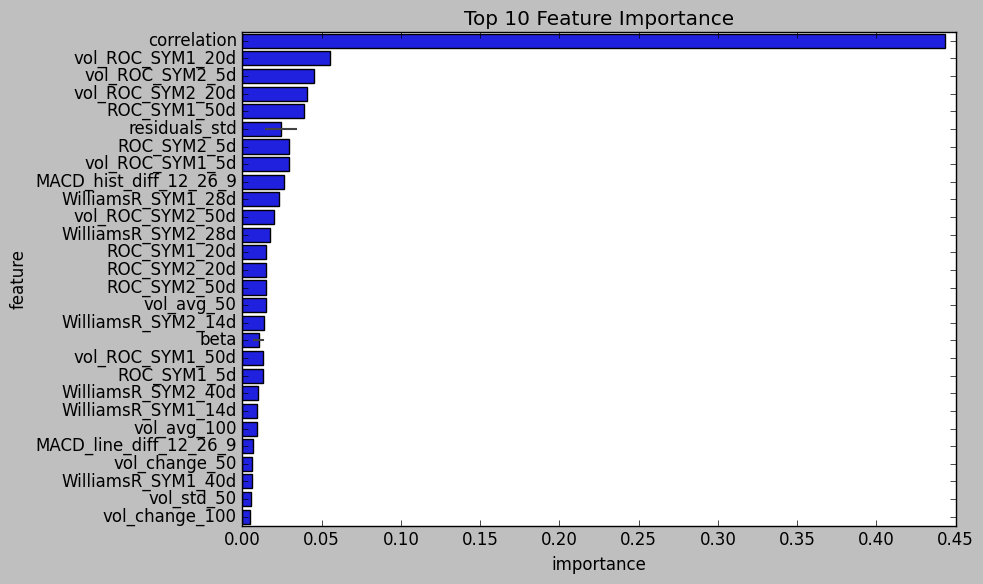

In [165]:
importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_model_retrained.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance.head(30), x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()

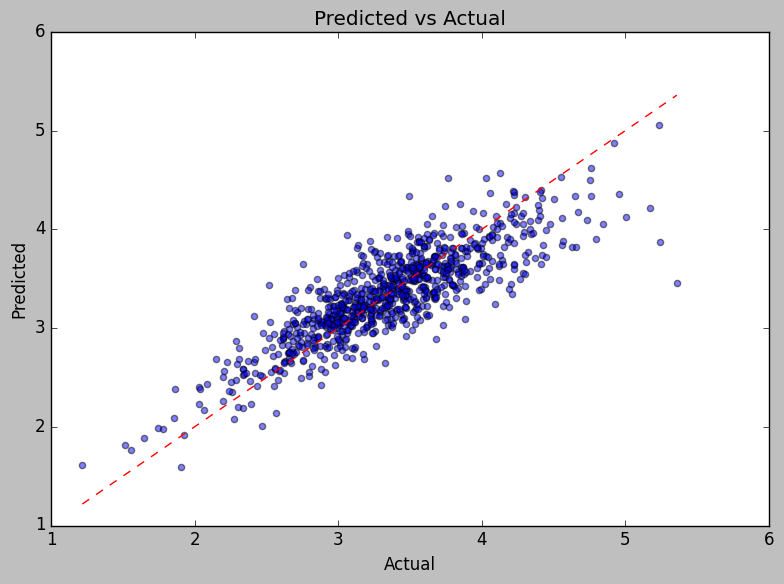

In [166]:
# Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()

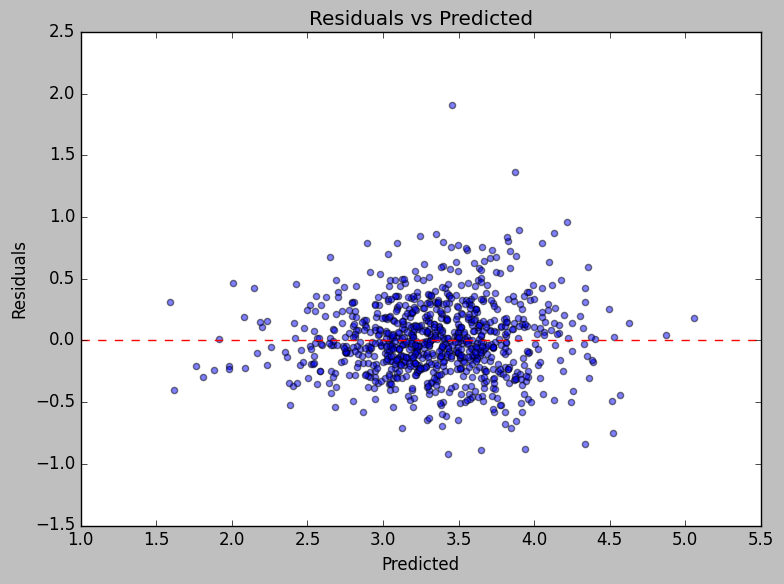

In [167]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

### Walk-Forward Evaluation

Walk-Forward Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded data from 2021-02-02 00:00:00 to 2024-01-01 00:00:00
Total symbols: 94
Total trading days: 733


Walk-Forward Iteration:  20%|██        | 1/5 [01:45<07:00, 105.07s/it]

Loaded data from 2021-05-03 00:00:00 to 2024-03-31 00:00:00
Total symbols: 94
Total trading days: 732


Walk-Forward Iteration:  40%|████      | 2/5 [03:29<05:13, 104.65s/it]

Loaded data from 2021-08-01 00:00:00 to 2024-06-29 00:00:00
Total symbols: 94
Total trading days: 732


Walk-Forward Iteration:  60%|██████    | 3/5 [05:13<03:28, 104.44s/it]

Loaded data from 2021-10-30 00:00:00 to 2024-09-27 00:00:00
Total symbols: 94
Total trading days: 731


Walk-Forward Iteration:  80%|████████  | 4/5 [06:57<01:44, 104.32s/it]

Loaded data from 2022-01-28 00:00:00 to 2024-12-26 00:00:00
Total symbols: 94
Total trading days: 732


Walk-Forward Iteration: 100%|██████████| 5/5 [08:42<00:00, 104.40s/it]


Walk-Forward Validierungsergebnisse:
           TRAIN_START            TRAIN_END        R2       MSE       MAE
0  2021-02-02 00:00:00  2024-01-01 00:00:00  0.712336  0.092487  0.231246
1  2021-05-03 00:00:00  2024-03-31 00:00:00  0.699582  0.094807  0.239860
2  2021-08-01 00:00:00  2024-06-29 00:00:00  0.663666  0.110894  0.259604
3  2021-10-30 00:00:00  2024-09-27 00:00:00  0.694749  0.092999  0.238013
4  2022-01-28 00:00:00  2024-12-26 00:00:00  0.674262  0.095675  0.238993

Durchschnittliche Metriken über alle Walk-Forward-Schritte:
R2     0.688919
MSE    0.097373
MAE    0.241543
dtype: float64


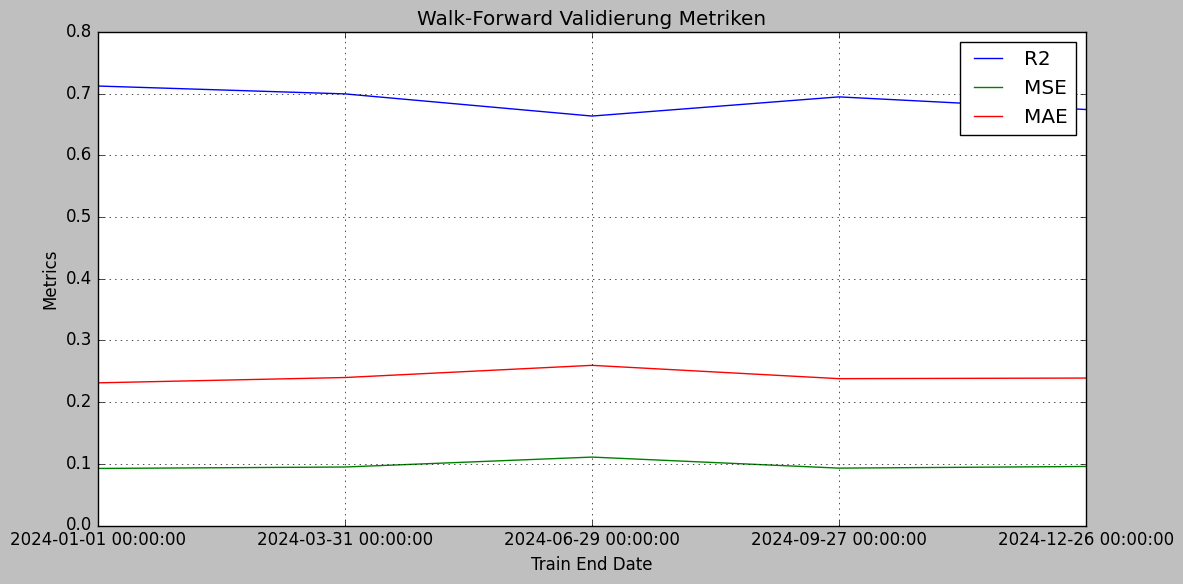

In [168]:
walk_forward_dates = []
current_train_start = DATE_CONFIG['TRAIN_START']
current_train_end = DATE_CONFIG['TRAIN_END']
step_size = timedelta(days=90)  
while current_train_end <= DATE_CONFIG['TEST_END']:
    walk_forward_dates.append({
        'TRAIN_START': current_train_start,
        'TRAIN_END': current_train_end
    })
    current_train_start += step_size
    current_train_end += step_size

walk_forward_results = []

for wf_config in tqdm(walk_forward_dates, desc="Walk-Forward Iteration"):
    DATE_CONFIG['TRAIN_START'] = wf_config['TRAIN_START']
    DATE_CONFIG['TRAIN_END'] = wf_config['TRAIN_END']

    df, price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'], DATE_CONFIG['TRAIN_START'],
                                                      DATE_CONFIG['TRAIN_END'])
    returns_matrix = price_matrix.pct_change().dropna()

    scaler = StandardScaler()
    standardized_returns = pd.DataFrame(
        scaler.fit_transform(returns_matrix),
        index=returns_matrix.index,
        columns=returns_matrix.columns
    )

    rolling_correlations = calculate_rolling_correlation(standardized_returns)
    rolling_correlations = rolling_correlations.dropna()
    rolling_betas = calculate_rolling_betas(standardized_returns)
    rolling_betas = rolling_betas.dropna()
    rolling_residuals_std = calculate_residuals_std(standardized_returns)
    rolling_residuals_std = rolling_residuals_std.dropna()
    average_spread_deviation = calculate_spread_deviation(standardized_returns)
    average_spread_deviation = average_spread_deviation.dropna()

    feature_df = pd.DataFrame({
        'correlation': rolling_correlations.iloc[-1],
        'beta': rolling_betas.iloc[-1],
        'residuals_std': rolling_residuals_std.iloc[-1]
    })
    feature_df['target'] = average_spread_deviation
    feature_df = feature_df.dropna()

    volume_matrix = df.pivot(index='date', columns='symbol', values='volume')
    volume_features = calculate_volume_features(volume_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df[['correlation', 'beta', 'residuals_std', 'target']], volume_features], axis=1)
    roc_features = calculate_roc_features(price_matrix, volume_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, roc_features], axis=1)
    williams_r_features = calculate_williams_r_features(price_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, williams_r_features], axis=1)
    bollinger_bands_features = calculate_bollinger_bands_width(standardized_returns, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, bollinger_bands_features], axis=1)
    macd_features = calculate_macd_features(price_matrix, rolling_correlations.columns)
    feature_df = pd.concat([feature_df, macd_features], axis=1)

    X = feature_df[feature_columns]
    y = feature_df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)  # Beachte: Test hier ist Validierung im Walk-Forward

    best_params_grid_search = {'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2,
                               'n_estimators': 300}
    final_model_retrained = GradientBoostingRegressor(**best_params_grid_search, random_state=42)
    final_model_retrained.fit(X_train, y_train)
    y_pred = final_model_retrained.predict(X_test)

    results = {
        'TRAIN_START': str(DATE_CONFIG['TRAIN_START']),
        'TRAIN_END': str(DATE_CONFIG['TRAIN_END']),
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    walk_forward_results.append(results)

walk_forward_df = pd.DataFrame(walk_forward_results)

print("\nWalk-Forward Validierungsergebnisse:")
print(walk_forward_df)


average_metrics = walk_forward_df[['R2', 'MSE', 'MAE']].mean()
print("\nDurchschnittliche Metriken über alle Walk-Forward-Schritte:")
print(average_metrics)

plt.figure(figsize=(12, 6))
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['R2'], label='R2')
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['MSE'], label='MSE')
plt.plot(walk_forward_df['TRAIN_END'], walk_forward_df['MAE'], label='MAE')
plt.xlabel('Train End Date')
plt.ylabel('Metrics')
plt.title('Walk-Forward Validierung Metriken')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()